# 10-1. 들어가며

학습 목표

1. 트랜스포머를 사용하여 번역기 만들기

사전 준비

1. 한글 폰트 준비

2. konlpy 한국어 형태소 설치

In [ ]:
# 한글 폰트 설치하기
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

In [ ]:
# 필요한 라이브러리 불러오기

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.9.2


# 10-2. 내부 모듈 구현하기

Tensor로 변환한 입력데이터가 주어졌다고 가정하고 생각해본다.

최초의 입력 데이터는 [batch_size * length]의 형태를 가지고 있다.

번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를 가지게 됩니다. 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이다.

모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 Shape가 바뀌는 과정은 다음과 같다.

1. 입력 데이터 → [ batch_size x length ]

2. Source & Target Embedding → [ batch_size x length x d_emb ]

3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.

4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.

1) Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]

2) Masking for Masked Attention

3) Scaled Dot Product Attention

4)Combine Heads →[ batch_size x length x d_emb ]

5. Residual Connection

6. Layer Normalization

7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]

8. Output Linear Layer → [ batch_size x length x vocab_size ]

트랜스포머의 가장 첫 단계인 Positional Encoding부터 다시 보도록한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-5.jpg)
<center>Positional Encoding</center>

In [ ]:
# Positional Encoding 구현

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

두 번째 구현은 Multi-Head Attention이다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-8.jpg)
<center>Multi-Head Attention</center>

Multi-Head-Attention은 여러 개의 서브 모듈울 결합하여 완성시킨다. Embedding된 입력을 Head 수로 분할하는 split_heads(), 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention(), 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads() 까지 MultiHeadAttention 클래스를 정의한다.

MultiHeadAttention 클래스를 정의할 때 Masking부분을 반드시 포함시켜준다.

마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의되는 것이 맞다.
마스크를 생성하는 함수는 모델을 완성한 후에 구현하도록 하겠습니다. 대신 생성된 마스크를 처리할 수 있도록 scaled_dot_product_attention() 에는 아래 한 줄을 포함시킨다

scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK

if mask is not None: scaled_qk += (mask * -1e9)

In [ ]:
# MultiHeadAttention class 구현

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    self.depth = d_model // self.num_heads

    self.W_q = tf.keras.layers.Dense(d_model)
    self.W_k = tf.keras.layers.Dense(d_model)
    self.W_v = tf.keras.layers.Dense(d_model)

    self.linear = tf.keras.layers.Dense(d_model)

  def scaled_dot_product_attention(self, Q, K, V, mask):
    d_k = tf.cast(K.shape[-1], tf.float32)
    QK = tf.matmul(Q, K, transpose_b = True)

    scaled_qk = QK / tf.math.sqrt(d_k)

    if mask is not None: scaled_qk += (mask * -1e9)

    attentions = tf.nn.softmax(scaled_qk, axis = -1)
    out = tf.matmul(attentions, V)

    return out, attentions

  def split_heads(self, x):
    batch_size = x.shape[0]
    split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    split_x = tf.transpose(split_x, perm = [0,2,1,3])

    return split_x

  def combine_heads(self, x):
    batch_size = x.shape[o]
    combined_x = tf.transpose(x, perm = [0,2,1,3])
    combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

    return combined_x

  def call(self, Q, K, V, mask):
    WQ = self.W_q(Q)
    WK = self.W_k(K)
    WV = self.W_v(V)

    WQ_splits = self.split_heads(WQ)
    WK_splits = self.split_heads(WK)
    WV_splits = self.split_heads(WV)

    out, attention_weights = self.scaled_dot_product_attention(
        WQ_splits, WK_splits, WV_splits, mask)
    
    out = self.combine_heads(out)
    out = self.linear(out)

    return out, attention_weights

세 번째 구현은 Position-wise Feed-Forward Network이다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-17.jpg)
<center>Position-wise Feed-Forward Network</center>



In [ ]:
# Position-wise Feed-Forward Network 구현
# 논문 설명 상 d_ff : 2048, d_model : 512이다.
# [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 
# 다시 w_2 를 통해 512차원으로 되돌리는 과정이다.

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
  def __init__(self, d_model, d_ff):
    super(PoswiseFeedForwardNet, self).__init__()
    self.w_1 = tf.keras.layers.Dense(d_ff, activations = 'relu')
    self.w_2 = tf.keras.layers.Dense(d_model)

  def call(self, x):
    out = self.W_1(x)
    out = self.W_2(out)

    return out

# 10-3. 모듈 조립하기

10-2에서 내부에 포함될 모듈을 완성시켰다. 이 모듈을 가지고 트랜스포머를 완성할 수 있는데, 정확히는 트랜스포머의 인코더 한 층과 디코더 한 층을 각각 완성할 수 있다. 물론 그렇다고 이 코드를 6번씩 작성할 필요는 없다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-5-P_transformer_table01.max-800x600.png)
<center>트랜스포머 실험 과정</center>

이런 실험을 하기위해서는 모델이 동적으로 완성되어야한다. 즉, 레이어 수를 원하는 만큼 쌓아 실험을 자유자래로 할 수 있게 모델을 완성해야한다.

방법은 단순하다. 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의하면 된다.



In [ ]:
# 여러 레이어를 한번에 쌓는 방법

N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]

첫 번째 구현은 Encoder 레이어 구현하기이다.

In [ ]:
# EncoderLayer 구현

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, n_heads, d_ff, dropout):
    super(EncoderLayer, self).__init__()

    self.enc_self_attn = MultiHeadAttention(d_model, n_heads)

    self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

    self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout = tf.keras.layers.Dorpout(dropout)

  def call(self, x, mask):
    """
    Multi-Head Attention
    """
    residual = x
    out = self.norm_1(x)
    out, enc_attn = self.enc_self_attn(out, out, out, mask)
    out = self.dropout(out)
    out += residual

    """
    Position-Wise Feed Forward Network
    """
    residual = out
    out = self.norm_2(out)
    out = self.ffn(out)
    out = self.dropout(out)
    out += residual

    return out, enc_attn

Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온답니다. 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했어요.

트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표되었습니다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명하고 있습니다.



두 번째 구현은 Decoder 레이어 구현하기이다.

In [ ]:
# DecoderLayer 구현

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, n_heads, d_ff, dropout):
    super(DecoderLayer, self).__init__()

    self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
    self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)

    self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

    self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout = tf.keras.layers.Dorpout(dropout)

  def call(self, x, enc_out, causality_mask, padding_mask):
    """
    Masked Multi-Head Attention
    """
    residual = x
    out = self.norm_1(x)
    out, dec_attn = self.enc_self_attn(out, out, out, padding_mask)
    out = self.dropout(out)
    out += residual

    """
    Masked Multi-Head Attention
    """
    residual = out
    out = self.norm_2(out)
    out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
    out = self.dropout(out)
    out += residual

    """
    Position-Wise Feed Forward Network
    """
    residual = out
    out = self.norm_3(out)
    out = self.ffn(out)
    out = self.dropout(out)
    out += residual

    return out, dec_attn, dec_enc_attn

In [ ]:
# Encoder 정의

class Encoder(tf.keras.Model):
  def __intit(self, n_layers, d_model, n_heads, d_ff, dropout):
    super(Encoder, self).__init__()
    self.n_layers = n_layers
    self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
    for _ in range(n_layers)]

  def call(self, x, mask):
    out = x

    enc_attns = list()
    for i in range(self.n_layers):
      out, enc_attn = self.enc_layers[i](out, mask)
      enc_attns.append(enc_attn)

    return out, enc_attns

In [ ]:
# Decoder 정의

class Decoder(tf.keras.Model):
  def __intit(self, n_layers, d_model, n_heads, d_ff, dropout):
    super(Decoder, self).__init__()
    self.n_layers = n_layers
    self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
    for _ in range(n_layers)]

  def call(self, x, enc_out, causality_mask, padding_mask):
    out = x
    
    dec_attns = list()
    dec_enc_attns = list()
    for i in range(self.n_layers):
      out, dec_attn, dec_enc_attn = self.enc_layers[i](out, enc_out, causality_mask, padding_mask)

      dec_attns.append(dec_attn)
      dec_enc_attns.append(dec_enc_attn)

    return out, dec_attns, dec_enc_attns

마지막은 트랜스포머 완성하기이다.

다음 조건을 만족하는 트랜스포머 클래스를 구현하자.

1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게하라.
- Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야한다. (참고: tf.keras.layers.Layer.set_weights())

2. 앞에서 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하라 (참고: tf.expand_dims(), np.newaxis)


In [ ]:
# 트랜스포머 구현하기

class Transformer(tf.keras.Model):
  def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
               pos_len, dropout = 0.2, shared = True):
    super(Transformer, self).__init()
    self.d_model = tf.casr(d_model, tf.float32)

    self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
    self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

    self.pos_encoding = positional_encoding(pos_len, d_model)
    self.dropout = tf.keras.layers.Dropout(dropout)

    self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
    self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

    self.fc = tf.keras.layers.Dense(tgt_vocab_size)

    self.shared = shared

    if shared : self.fc.set_weights(tf.transpose(self.dec_emb.weights))

  def embedding(self, emb, x):
    seq_len = x.shape[1]
    out = emb(x)

    if self.shared : out *= tf.math.sqrt(self.d_model)

    out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
    out = self.dropout(out)

  def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
    enc_in = self.embedding(self.enc_emb, enc_in)
    dec_in = self.embedding(self.dec_emb, dec_in)

    enc_out, enc_attns = self.encoder(enc_in, enc_mask)

    dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)

    logits = self.fc(dec_out)
        
    return logits, enc_attns, dec_attns, dec_enc_attns

# 10-4. 모델 밖의 조력자들

모델 외적인 부분을 추가적으로 더 구현해보도록 한다.

In [ ]:
# Masking 내용 추가

import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
  mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
  return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
  enc_mask = generate_padding_mask(src)
  dec_mask = generate_padding_mask(tgt)

  dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
  dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

  dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
  dec_mask = tf.maximum(dec_mask, dec_causality_mask)

  return enc_mask, dec_enc_mask, dec_mask

generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했죠? 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다.

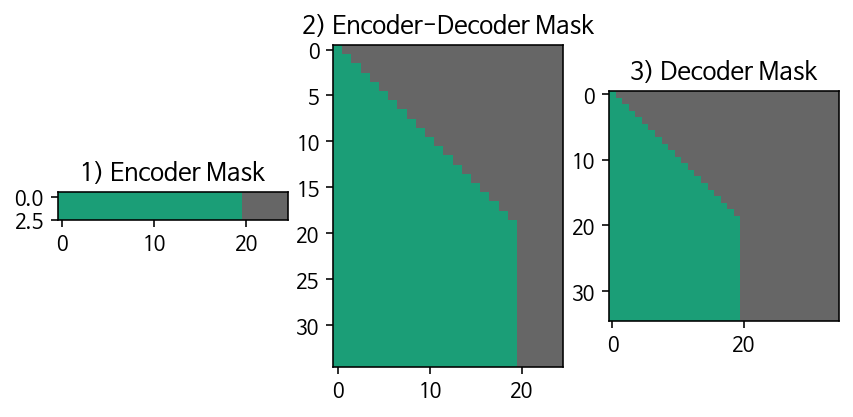

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking하는 형태임을 알 수 있습니다. 두 번째와 세 번째가 바로 Causality Mask와 Padding Mask를 결합한 형태입니다.

자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했었다. 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된다.

또한 트랜스포머는 고정된 학습률을 사용하지 않는다. 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 보도록한다. 이전 노드에서 Learning Rate를 numpy 로 간단히 구현을 했었는데, 이번엔 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현한다.

In [ ]:
# LearningRateScheduler 구현

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps = 4000):
    super(LearningRateScheduler, self).__init__()
    self.d_model = d_model
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = step ** -0,5
    arg2 = step * (self.warmup_steps ** -1.5)

    return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하시면 됩니다. Optimizer와 Scheduler를 연결하는 과정도 아주 간단하죠! Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줍니다.